<a href="https://colab.research.google.com/github/jiiinchoi/MAI-Lab./blob/main/Nucleiseg2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jiinchoiii","key":"593dcbc01e049c2cadd7a35210df2076"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
# 데이터 다운로드
!kaggle datasets download -d espsiyam/nuclei-image-segmentation -p /content

# 압축 해제
!unzip -oq /content/nuclei-image-segmentation.zip -d /content/nuclei


Dataset URL: https://www.kaggle.com/datasets/espsiyam/nuclei-image-segmentation
License(s): CC0-1.0
 41% 37.0M/89.4M [00:00<00:00, 380MB/s]
100% 89.4M/89.4M [00:00<00:00, 467MB/s]


In [36]:
import os, sys, random, cv2, numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (Input, Lambda, Conv2D, MaxPooling2D, Dropout,
                                     UpSampling2D, concatenate, BatchNormalization)
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.morphology import remove_small_objects

Image_height = 256
Image_width  = 256
num_of_channels = 3

train_path = "/content/nuclei/U_NET/train"
test_path  = "/content/nuclei/U_NET/test"

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)


In [47]:
# 메모리 할당
X_train = np.zeros((len(train_Ids), Image_height, Image_width, num_of_channels), dtype=np.uint8)
print(X_train.shape)

Y_train = np.zeros((len(train_Ids), Image_height, Image_width, 1), dtype=np.uint8)
print(Y_train.shape)
sys.stdout.flush()

# train 이미지/마스크 읽기
for n, id in tqdm(enumerate(train_Ids), total=len(train_Ids)):
    path = os.path.join(train_path, id)

    # 이미지
    img = imread(os.path.join(path, "images", id + ".png"))
    img = ensure_3ch(img)[:, :, :num_of_channels].astype(np.uint8)
    img = resize_image_cv(img)
    X_train[n] = img

    # 마스크 (
    mask = np.zeros((Image_height, Image_width, 1), dtype=np.uint8)
    mdir = os.path.join(path, "masks")
    if os.path.isdir(mdir):
        for mask_file in os.listdir(mdir):
            m = imread(os.path.join(mdir, mask_file))
            m = resize_mask_cv(m)[..., None]
            mask = np.maximum(mask, m)         # 여러 조각 합치기
    Y_train[n] = mask

# Tensor 변환
x_train = tf.constant(X_train, dtype=tf.float32, name="cell_input")
y_train = tf.constant(Y_train.astype(np.float32), dtype=tf.float32, name="cell_label")


X_test = np.zeros((len(test_Ids), Image_height, Image_width, num_of_channels), dtype=np.uint8)
print(X_test.shape)

test_sizes = []

# 테스트 이미지 읽기
for n, id in tqdm(enumerate(test_Ids), total=len(test_Ids)):
    path = os.path.join(test_path, id)
    img_test = imread(os.path.join(path, "images", id + ".png"))[:, :, :num_of_channels]

    # 원본 크기 저장 (업샘플링용)
    test_sizes.append([img_test.shape[0], img_test.shape[1]])

    # 리사이즈
    img_test = resize(img_test, (Image_height, Image_width), mode="constant", preserve_range=True)
    X_test[n] = img_test

# Tensor 변환
x_test = tf.constant(X_test, dtype=tf.float32, name="x_test")
print("Done!")


(669, 256, 256, 3)
(669, 256, 256, 1)


100%|██████████| 669/669 [00:44<00:00, 15.16it/s]


(65, 256, 256, 3)


100%|██████████| 65/65 [00:01<00:00, 37.95it/s]

Done!


In [48]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (Input, Lambda, Conv2D, MaxPooling2D, Dropout,
                                     concatenate, UpSampling2D)
from tensorflow.keras.models import Model

# metrics
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    inter = K.sum(y_true_f * y_pred_f)
    return (2.*inter + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

def iou(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true); y_pred_f = K.flatten(y_pred)
    inter = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

#U-Net
inputs = Input((Image_height, Image_width, num_of_channels))
s = Lambda(lambda x: x / 255.0)(inputs)  # 입력 정규화

def block(x, f, drop=0.0):
    x = Conv2D(f, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    if drop: x = Dropout(drop)(x)
    x = Conv2D(f, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    return x

# Encoder
c1 = block(s, 16, 0.1); p1 = MaxPooling2D(2)(c1)
c2 = block(p1, 32, 0.1); p2 = MaxPooling2D(2)(c2)
c3 = block(p2, 64, 0.2); p3 = MaxPooling2D(2)(c3)
c4 = block(p3,128, 0.2); p4 = MaxPooling2D(2)(c4)

# Bottleneck
c5 = block(p4,256, 0.3)

# Decoder
u6 = UpSampling2D(2, interpolation='bilinear')(c5)
u6 = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal')(u6)
u6 = concatenate([u6, c4])
c6 = block(u6, 128, 0.2)

u7 = UpSampling2D(2, interpolation='bilinear')(c6)
u7 = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(u7)
u7 = concatenate([u7, c3])
c7 = block(u7, 64, 0.2)

u8 = UpSampling2D(2, interpolation='bilinear')(c7)
u8 = Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_normal')(u8)
u8 = concatenate([u8, c2])
c8 = block(u8, 32, 0.1)

u9 = UpSampling2D(2, interpolation='bilinear')(c8)
u9 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(u9)
u9 = concatenate([u9, c1])
c9 = block(u9, 16, 0.1)

outputs = Conv2D(1, 1, activation='sigmoid')(c9)
model = Model(inputs, outputs)

# 안정적인 학습을 위해 LR 낮추고 BCE+Dice 사용
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=bce_dice_loss,
              metrics=[dice_coef, iou])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 256, 256,  │          0 │ input_layer_3[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 256, 256,  │        448 │ lambda_3[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 256, 256,  │          0 │ conv2d_69[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_27[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ conv2d_70[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 128, 128,  │          0 │ conv2d_71[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_28[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 64, 64,    │          0 │ conv2d_72[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 64, 64,    │          0 │ conv2d_73[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_29[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 32, 32,    │          0 │ conv2d_74[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_14… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 32, 32,    │          0 │ conv2d_75[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_30[0][0]

 Total params: 2,158,705 (8.23 MB)

 Trainable params: 2,158,705 (8.23 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
ckpt = tf.keras.callbacks.ModelCheckpoint("unet_best.keras",
                                          monitor="val_dice_coef", mode="max",
                                          save_best_only=True, verbose=1)
early = tf.keras.callbacks.EarlyStopping(monitor="val_dice_coef", mode="max",
                                         patience=8, restore_best_weights=True, verbose=1)
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_dice_coef", mode="max",
                                               factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(x_train, y_train,
                    validation_split=0.1,
                    epochs=100,
                    batch_size=8,
                    callbacks=[ckpt, early, plateau],
                    shuffle=True)




Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - dice_coef: 0.2080 - iou: 0.1171 - loss: 1.3710
Epoch 1: val_dice_coef improved from -inf to 0.32877, saving model to unet_best.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 44s 319ms/step - dice_coef: 0.2084 - iou: 0.1173 - loss: 1.3692 - val_dice_coef: 0.3288 - val_iou: 0.1975 - val_loss: 0.9709 - learning_rate: 1.0000e-04
Epoch 2/100
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - dice_coef: 0.4191 - iou: 0.2676 - loss: 0.8234
Epoch 2: val_dice_coef did not improve from 0.32877
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - dice_coef: 0.4207 - iou: 0.2690 - loss: 0.8211 - val_dice_coef: 0.2839 - val_iou: 0.1681 - val_loss: 1.1707 - learning_rate: 1.0000e-04
Epoch 3/100
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - dice_coef: 0.5889 - iou: 0.4229 - loss: 0.6513
Epoch 3: val_dice_coef improved from 0.32877 to 0.61910, saving model to unet_best.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - dice_coef: 0.5904 - iou: 0.4245 - loss: 0.6487 - val_dice_coef: 

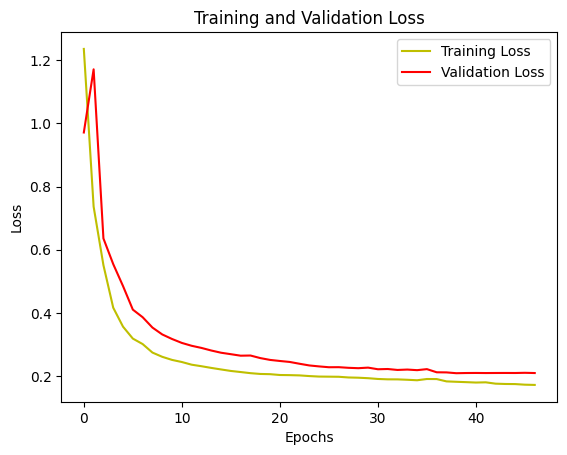

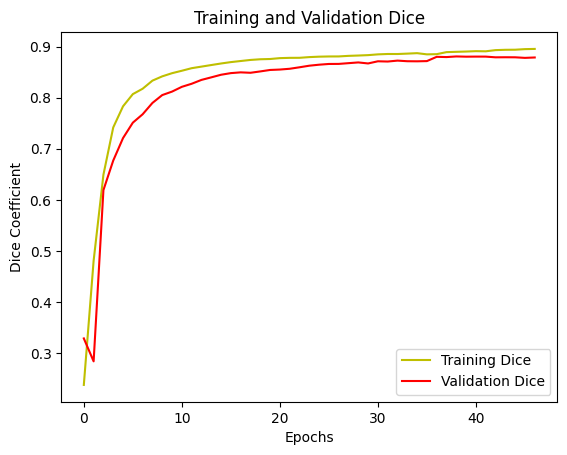

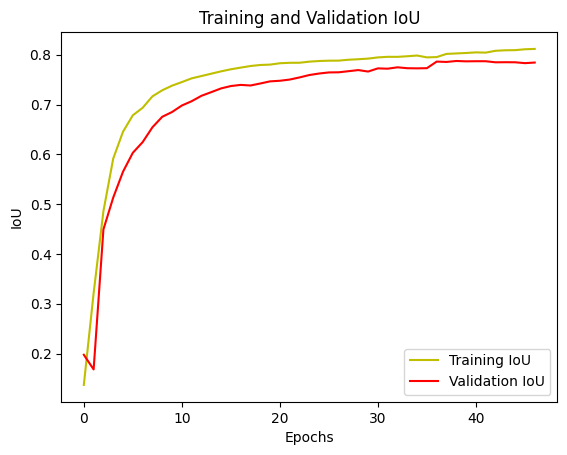

In [50]:
# 학습/검증 Loss
plt.plot(history.history['loss'], 'y', label='Training Loss')
plt.plot(history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Dice
plt.plot(history.history['dice_coef'], 'y', label='Training Dice')
plt.plot(history.history['val_dice_coef'], 'r', label='Validation Dice')
plt.title('Training and Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

# IOU
plt.plot(history.history['iou'], 'y', label='Training IoU')
plt.plot(history.history['val_iou'], 'r', label='Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()


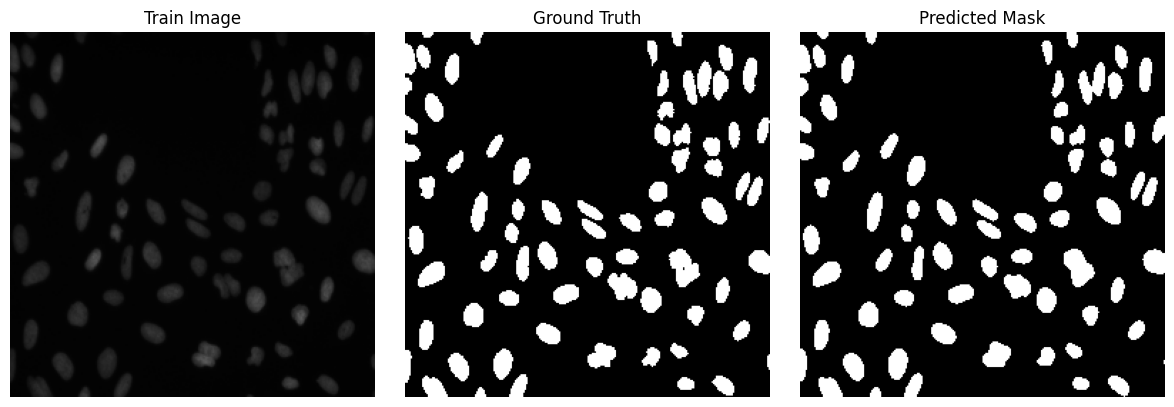

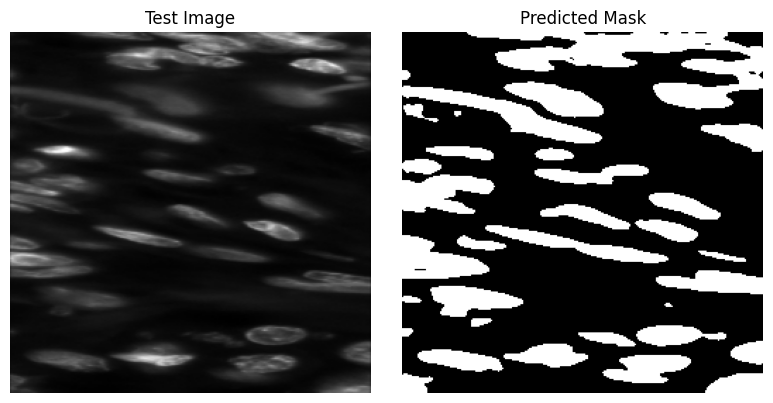

In [59]:
import random
import matplotlib.pyplot as plt

thr = 0.45

#Train에서 랜덤
i = random.randint(0, x_train.shape[0]-1)
pred_prob = model.predict(x_train[i:i+1], verbose=0)[0, ..., 0]
pred_mask = (pred_prob > thr).astype(np.uint8)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(X_train[i].astype(np.uint8))
plt.axis('off'); plt.title("Train Image")

plt.subplot(1,3,2)
plt.imshow(Y_train[i, ..., 0].astype(np.uint8), cmap='gray', vmin=0, vmax=1)
plt.axis('off'); plt.title("Ground Truth")

plt.subplot(1,3,3)
plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)
plt.axis('off'); plt.title("Predicted Mask")
plt.tight_layout()
plt.show()

#Test에서 랜덤
j = random.randint(0, x_test.shape[0]-1)
pred_prob_t = model.predict(x_test[j:j+1], verbose=0)[0, ..., 0]
pred_test = (pred_prob_t > thr).astype(np.uint8)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(X_test[j].astype(np.uint8))
plt.axis('off'); plt.title("Test Image")

plt.subplot(1,2,2)
plt.imshow(pred_test, cmap='gray', vmin=0, vmax=1)
plt.axis('off'); plt.title("Predicted Mask")
plt.tight_layout()
plt.show()
